# Inference

## Data Loading

In [6]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


In [7]:
import os
import numpy as np
import pandas as pd
import torch
import dill

test = pd.read_csv('sample_submission.csv')

def get_test_file_path(image_id):
    return "input/test/{}/{}/{}/{}.png".format(
        image_id[0], image_id[1], image_id[2], image_id 
    )

test['file_path'] = test['image_id'].apply(get_test_file_path)

print(f'test.shape: {test.shape}')
display(test.head())

test.shape: (1616107, 3)


,image_id,InChI,file_path
0,00000d2a601c,InChI=1S/H2O/h1H2,input/test/0/0/0/00000d2a601c.png
1,00001f7fc849,InChI=1S/H2O/h1H2,input/test/0/0/0/00001f7fc849.png
2,000037687605,InChI=1S/H2O/h1H2,input/test/0/0/0/000037687605.png
3,00004b6d55b6,InChI=1S/H2O/h1H2,input/test/0/0/0/00004b6d55b6.png
4,00004df0fe53,InChI=1S/H2O/h1H2,input/test/0/0/0/00004df0fe53.png


In [8]:
tokenizer = torch.load('input/inchi-preprocess/tokenizer.pth', pickle_module=dill)
print(f"tokenizer.stoi: {tokenizer.stoi}")

tokenizer.stoi: {'(': 0, ')': 1, '+': 2, ',': 3, '-': 4, '/b': 5, '/c': 6, '/h': 7, '/i': 8, '/m': 9, '/s': 10, '/t': 11, '0': 12, '1': 13, '10': 14, '100': 15, '101': 16, '102': 17, '103': 18, '104': 19, '105': 20, '106': 21, '107': 22, '108': 23, '109': 24, '11': 25, '110': 26, '111': 27, '112': 28, '113': 29, '114': 30, '115': 31, '116': 32, '117': 33, '118': 34, '119': 35, '12': 36, '120': 37, '121': 38, '122': 39, '123': 40, '124': 41, '125': 42, '126': 43, '127': 44, '128': 45, '129': 46, '13': 47, '130': 48, '131': 49, '132': 50, '133': 51, '134': 52, '135': 53, '136': 54, '137': 55, '138': 56, '139': 57, '14': 58, '140': 59, '141': 60, '142': 61, '143': 62, '144': 63, '145': 64, '146': 65, '147': 66, '148': 67, '149': 68, '15': 69, '150': 70, '151': 71, '152': 72, '153': 73, '154': 74, '155': 75, '156': 76, '157': 77, '158': 78, '159': 79, '16': 80, '161': 81, '163': 82, '165': 83, '167': 84, '17': 85, '18': 86, '19': 87, '2': 88, '20': 89, '21': 90, '22': 91, '23': 92, '24': 9

## CFG

In [9]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    max_len=275
    print_freq=1000
    num_workers=os.cpu_count()*2
    model_name='resnet34'
    size=224
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=1 # not to exceed 9h
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=4 # CosineAnnealingLR
    #T_0=4 # CosineAnnealingWarmRestarts
    encoder_lr=1e-4
    decoder_lr=4e-4
    min_lr=1e-6
    batch_size=64
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=5
    attention_dim=256
    embed_dim=256
    decoder_dim=512
    dropout=0.5
    seed=42
    n_fold=5
    trn_fold=[0] # [0, 1, 2, 3, 4]
    train=True
    
print(f'Using {os.cpu_count()*2} workers.')

Using 24 workers.


In [10]:
if CFG.debug:
    test = test.head(1000)

## Library

In [11]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('input/pytorch-image-models/pytorch-image-models-master')

import os
import gc
import re
import math
import time
import random
import shutil
import pickle
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import Levenshtein
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

cuda_available = torch.cuda.is_available()

device = torch.device('cuda' if cuda_available else 'cpu')

if (cuda_available):
    torch.cuda.init()
    print(f'CUDA available: {cuda_available}')
    print(f'Number of available devices: {torch.cuda.device_count()}')
    print(f'Device names: ')

    for i in np.arange(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available: True
Number of available devices: 1
Device names: 
NVIDIA GeForce RTX 2070 SUPER


## Utils

In [12]:
# ====================================================
# Utils
# ====================================================

def get_score(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        score = Levenshtein.distance(true, pred)
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score


def init_logger(log_file='inference.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False # True

seed_torch(seed=CFG.seed)

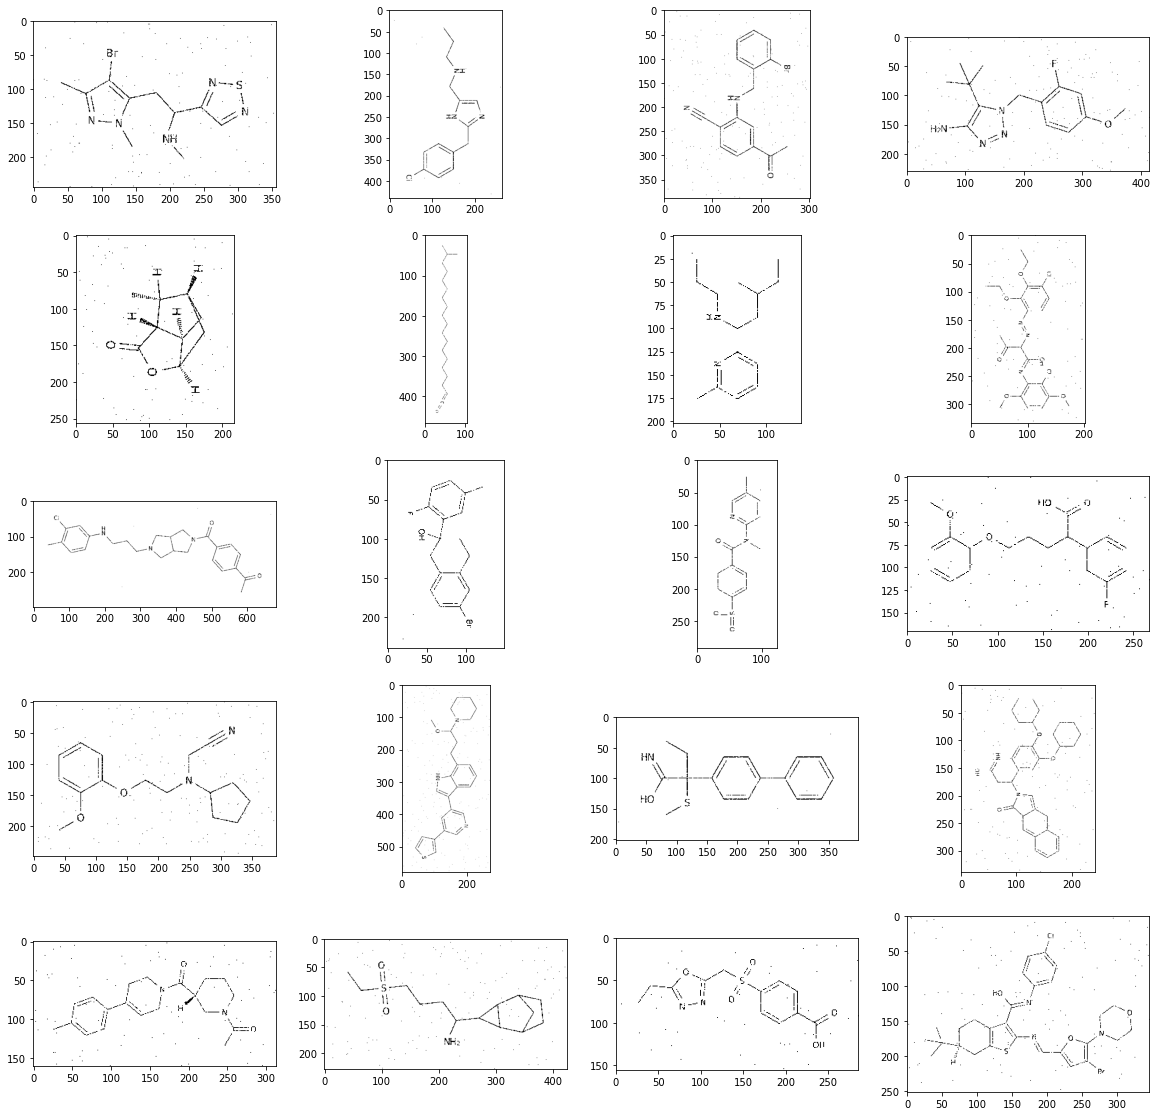

In [13]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 20))
for i in range(20):
    image = cv2.imread(test.loc[i, 'file_path'])
    plt.subplot(5, 4, i + 1)
    plt.imshow(image)
plt.show()

## Dataset

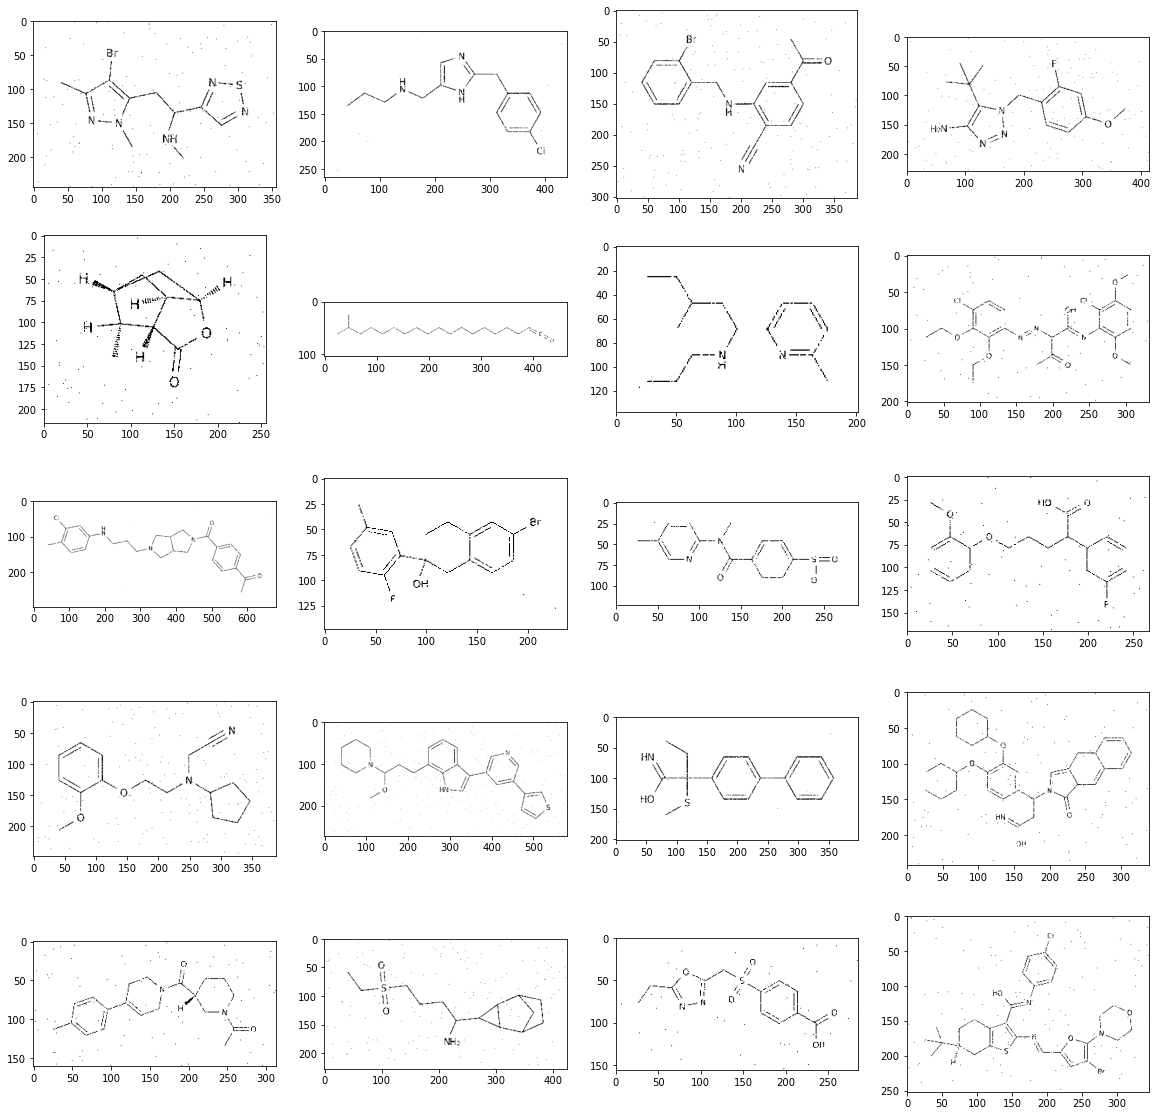

In [14]:
from matplotlib import pyplot as plt

transform = A.Compose([A.Transpose(p=1), A.VerticalFlip(p=1)])

plt.figure(figsize=(20, 20))
for i in range(20):
    image = cv2.imread(test.loc[i, 'file_path'])
    h, w, _ = image.shape
    if h > w:
        image = transform(image=image)['image']
    plt.subplot(5, 4, i + 1)
    plt.imshow(image)
plt.show()

In [15]:
# ====================================================
# Dataset
# ====================================================
class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df = df
        self.file_paths = df['file_path'].values
        self.transform = transform
        self.fix_transform = A.Compose([A.Transpose(p=1), A.VerticalFlip(p=1)])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        h, w, _ = image.shape
        if h > w:
            image = self.fix_transform(image=image)['image']
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

## Transforms

In [16]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

## MODEL

In [17]:
class Encoder(nn.Module):
    def __init__(self, model_name='resnet18', pretrained=False):
        super().__init__()
        self.cnn = timm.create_model(model_name, pretrained=pretrained)
        self.n_features = self.cnn.fc.in_features
        self.cnn.global_pool = nn.Identity()
        self.cnn.fc = nn.Identity()

    def forward(self, x):
        LOGGER.info('Encoder - Forwarding ..')
        bs = x.size(0)
        features = self.cnn(x)
        features = features.permute(0, 2, 3, 1)
        return features

In [18]:
class Attention(nn.Module):
    """
    Attention network for calculate attention value
    """
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: input size of encoder network
        :param decoder_dim: input size of decoder network
        :param attention_dim: input size of attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha


class DecoderWithAttention(nn.Module):
    """
    Decoder network with attention network used for training
    """

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, device, encoder_dim=512, dropout=0.5):
        """
        :param attention_dim: input size of attention network
        :param embed_dim: input size of embedding network
        :param decoder_dim: input size of decoder network
        :param vocab_size: total number of characters used in training
        :param encoder_dim: input size of encoder network
        :param dropout: dropout rate
        """
        super(DecoderWithAttention, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        self.device = device
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network
        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        :param encoder_out: output of encoder network
        :param encoded_captions: transformed sequence from character to integer
        :param caption_lengths: length of transformed sequence
        """
        LOGGER.info('Decoder - Forwarding ..')
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        # embedding transformed sequence for vector
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)
        # initialize hidden state and cell state of LSTM cell
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        # set decode length by caption length - 1 because of omitting start token
        decode_lengths = (caption_lengths - 1).tolist()
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(self.device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(self.device)
        # predict sequence
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind
    
    def predict(self, encoder_out, decode_lengths, tokenizer):
        LOGGER.info('Decoder - Predicting ..')
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        # embed start tocken for LSTM input
        start_tockens = torch.ones(batch_size, dtype=torch.long).to(self.device) * tokenizer.stoi["<sos>"]
        embeddings = self.embedding(start_tockens)
        # initialize hidden state and cell state of LSTM cell
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)
        predictions = torch.zeros(batch_size, decode_lengths, vocab_size).to(self.device)
        # predict sequence
        for t in range(decode_lengths):
            attention_weighted_encoding, alpha = self.attention(encoder_out, h)
            gate = self.sigmoid(self.f_beta(h))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings, attention_weighted_encoding], dim=1),
                (h, c))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:, t, :] = preds
            if np.argmax(preds.detach().cpu().numpy()) == tokenizer.stoi["<eos>"]:
                break
            embeddings = self.embedding(torch.argmax(preds, -1))
        return predictions

## Inference

In [19]:
def inference(test_loader, encoder, decoder, tokenizer, device):
    encoder.eval()
    decoder.eval()
    text_preds = []
    tk0 = tqdm(test_loader, total=len(test_loader))
    for images in tk0:
        
        images = images.to(device)
        with torch.no_grad():
            features = encoder(images)
            predictions = decoder.predict(features, CFG.max_len, tokenizer)
        predicted_sequence = torch.argmax(predictions.detach().cpu(), -1).numpy()
        _text_preds = tokenizer.predict_captions(predicted_sequence)
        text_preds.append(_text_preds)
    text_preds = np.concatenate(text_preds)
    return text_preds

In [ ]:
if __name__ == '__main__':

    states = torch.load(f'{CFG.model_name}_fold0_best.pth', map_location=torch.device('cpu'), pickle_module=dill)

    encoder = Encoder(CFG.model_name, pretrained=False)
    encoder.load_state_dict(states['encoder'])
    encoder.to(device)

    decoder = DecoderWithAttention(attention_dim=CFG.attention_dim,
                                   embed_dim=CFG.embed_dim,
                                   decoder_dim=CFG.decoder_dim,
                                   vocab_size=len(tokenizer),
                                   dropout=CFG.dropout,
                                   device=device)
    decoder.load_state_dict(states['decoder'])
    decoder.to(device)

    del states; gc.collect()

    test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=CFG.num_workers)
    predictions = inference(test_loader, encoder, decoder, tokenizer, device)

    del test_loader, encoder, decoder, tokenizer; gc.collect()

In [ ]:
# submission
test['InChI'] = [f"InChI=1S/{text}" for text in predictions]
test[['image_id', 'InChI']].to_csv('submission.csv', index=False)
test[['image_id', 'InChI']].head()
LOGGER.info('DONE')